## Imports

In [1]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from clique_finding_models.analysis import load_experiment_results, get_exp_ids_from_sacred_dir, \
    process_exp_results_to_df

## Load configs and metrics

In [2]:
SACRED_DIR = os.path.join(os.getcwd(), "outputs", "medium_500", "sacred")
changing_hparams = [
    "conv_layers",
    "hidden_layers",
    "learning_rate",
]

exp_ids = get_exp_ids_from_sacred_dir(SACRED_DIR)
exp_results = [load_experiment_results(os.path.join(SACRED_DIR, str(exp_id)))
               for exp_id in exp_ids]
results = process_exp_results_to_df(exp_ids, exp_results, changing_hparams)
results.loc[results.data_set == "medium_dimacs_bhoslib_500", "data_set"] = "all"
results.loc[results.train == True, "model"] = results.loc[results.train == True, "model"] + "_subset"
results.head()

,epochs,model,batch_size,tag,status,exp_id,transform_y,train,data_set,train.avep,...,val.top5,val.avep,train.mae,val.mae,train.top1,val.top1,val.mse,learning_rate,conv_layers,hidden_layers
0,2,mean_bl_subset,32,rel_deg,COMPLETED,1,relative_to_degree,True,all,0.809175,...,0.8776,0.807819,5.590852,5.528220,0.9275,0.934,54.918937,NaN,NaN,NaN
1,1,mean_bl,32,rel_deg,COMPLETED,2,relative_to_degree,False,C.50.5,NaN,...,0.7320,0.655731,NaN,3.789886,NaN,0.870,15.932833,NaN,NaN,NaN
2,1,mean_bl,32,rel_deg,COMPLETED,3,relative_to_degree,False,dsjc50,NaN,...,0.9480,0.922218,NaN,5.822286,NaN,0.960,52.554023,NaN,NaN,NaN
3,1,mean_bl,32,rel_deg,COMPLETED,4,relative_to_degree,False,rb9-6,NaN,...,0.8320,0.736811,NaN,6.439435,NaN,0.890,43.641092,NaN,NaN,NaN
4,1,mean_bl,32,rel_deg,COMPLETED,5,relative_to_degree,False,C.50.9,NaN,...,0.9760,0.862373,NaN,2.361834,NaN,0.990,7.100318,NaN,NaN,NaN


## Regression task

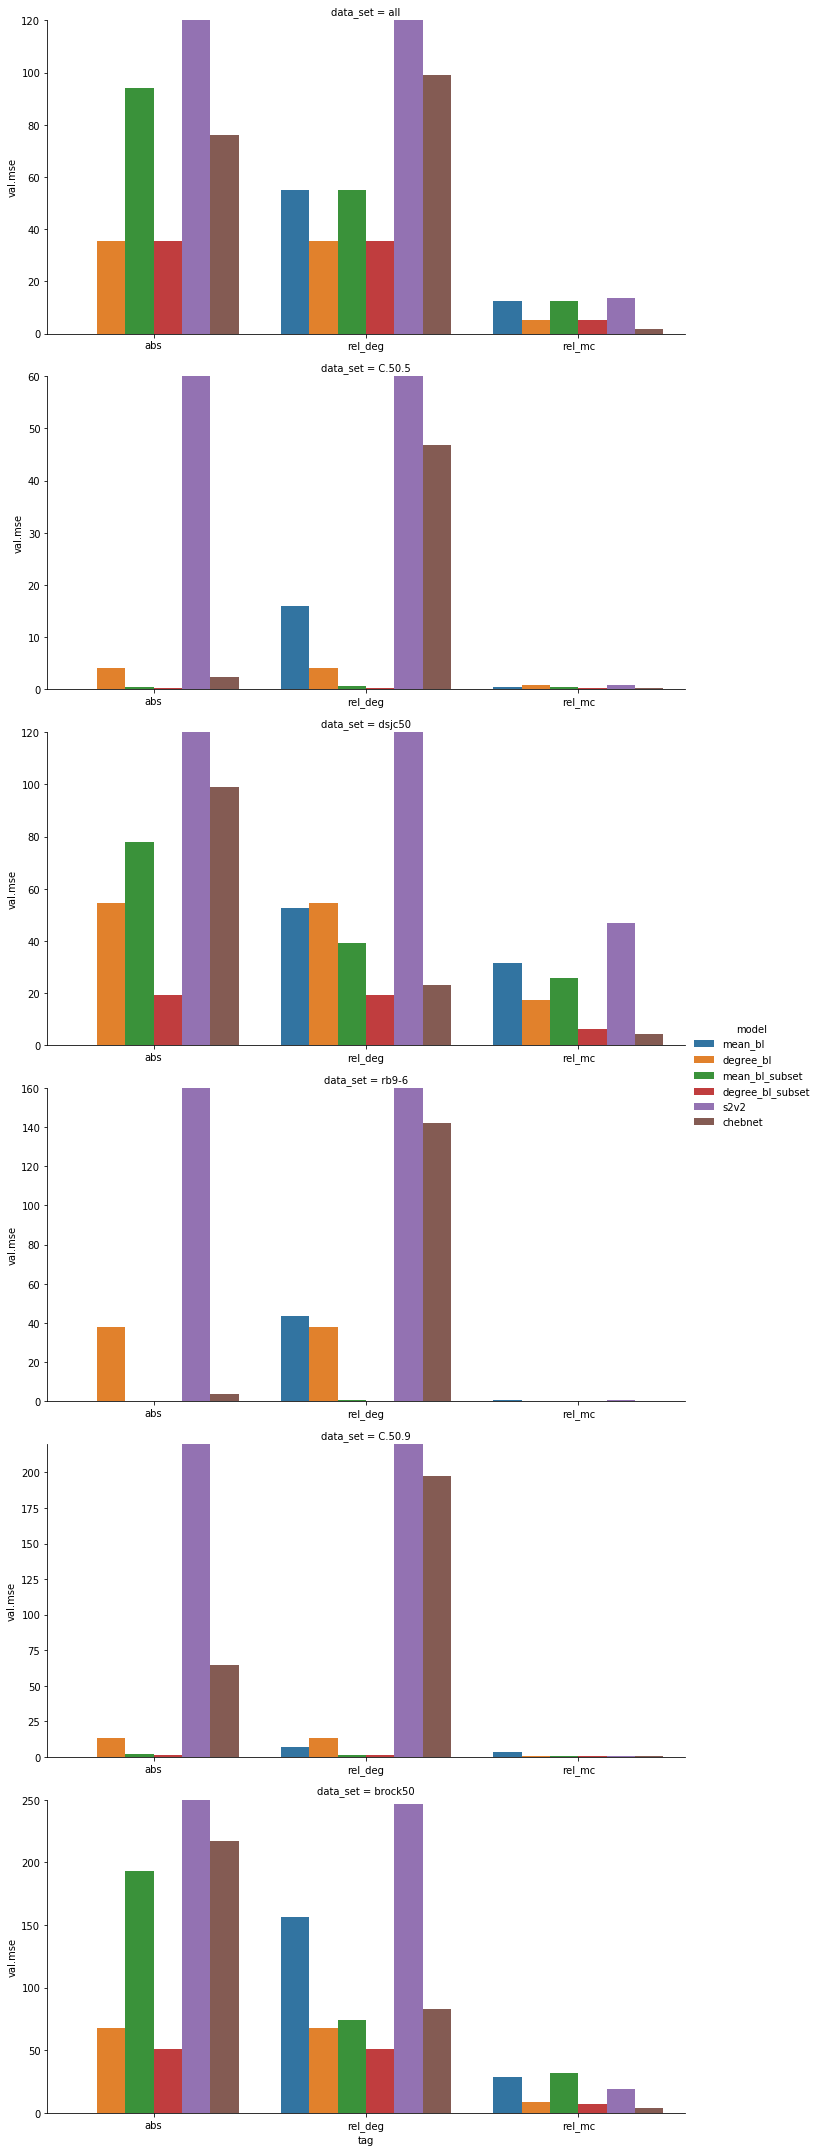

In [3]:
mse_model_order = ["mean_bl", "degree_bl", "mean_bl_subset", "degree_bl_subset", "s2v2", "chebnet"]
mse_tag_order = ["abs", "rel_deg", "rel_mc"]

grid = sns.catplot(data=results[((results.model != "mean_bl") | (results.tag != "abs"))], 
            x="tag", y="val.mse", row="data_set", hue="model",
            hue_order=mse_model_order, order=mse_tag_order, 
            kind="bar", sharey=False, aspect=2, sharex=False)

for i in range(6):
    grid.axes[i, 0].set_ylim(0, [120, 60, 120, 160, 220, 250][i])

### Generate table

In [4]:
col_order = [
    "mean_bl_subset+abs",
    "degree_bl_subset+abs",
    "s2v2+abs",
    "chebnet+abs",
    
    "mean_bl_subset+rel_deg",
    "degree_bl_subset+rel_deg",
    "s2v2+rel_deg",
    "chebnet+rel_deg",
]
table = results.loc[
    (results.model.isin(["mean_bl_subset", "degree_bl_subset", "s2v2", "chebnet"])) &
    (results.tag != "rank"), 
    ["model", "tag", "data_set", "val.mse", "val.mae"]].reset_index()
table["model_tag"] = table["model"] + "+" + table["tag"]
table = table.pivot("data_set", "model_tag", "val.mse").round(2)[col_order]
table

model_tag,mean_bl_subset+abs,degree_bl_subset+abs,s2v2+abs,chebnet+abs,mean_bl_subset+rel_deg,degree_bl_subset+rel_deg,s2v2+rel_deg,chebnet+rel_deg
data_set,,,,,,,,
C.50.5,0.42,0.34,1563.62,2.31,0.72,0.34,356.37,46.74
C.50.9,1.89,1.59,66231.35,64.55,1.77,1.59,585.17,197.08
all,94.25,35.55,26641.12,76.18,54.92,35.55,445.98,99.05
brock50,192.90,50.62,42653.29,217.06,74.27,50.62,246.26,82.57
dsjc50,77.79,19.35,5652.08,98.99,39.29,19.35,234.86,23.08
rb9-6,0.28,0.24,17811.62,3.80,0.79,0.24,780.47,142.34


In [5]:
# with open("outputs/gen_size_mse.tex", "w") as f:
#     f.write(table.to_latex())

## Ranking task

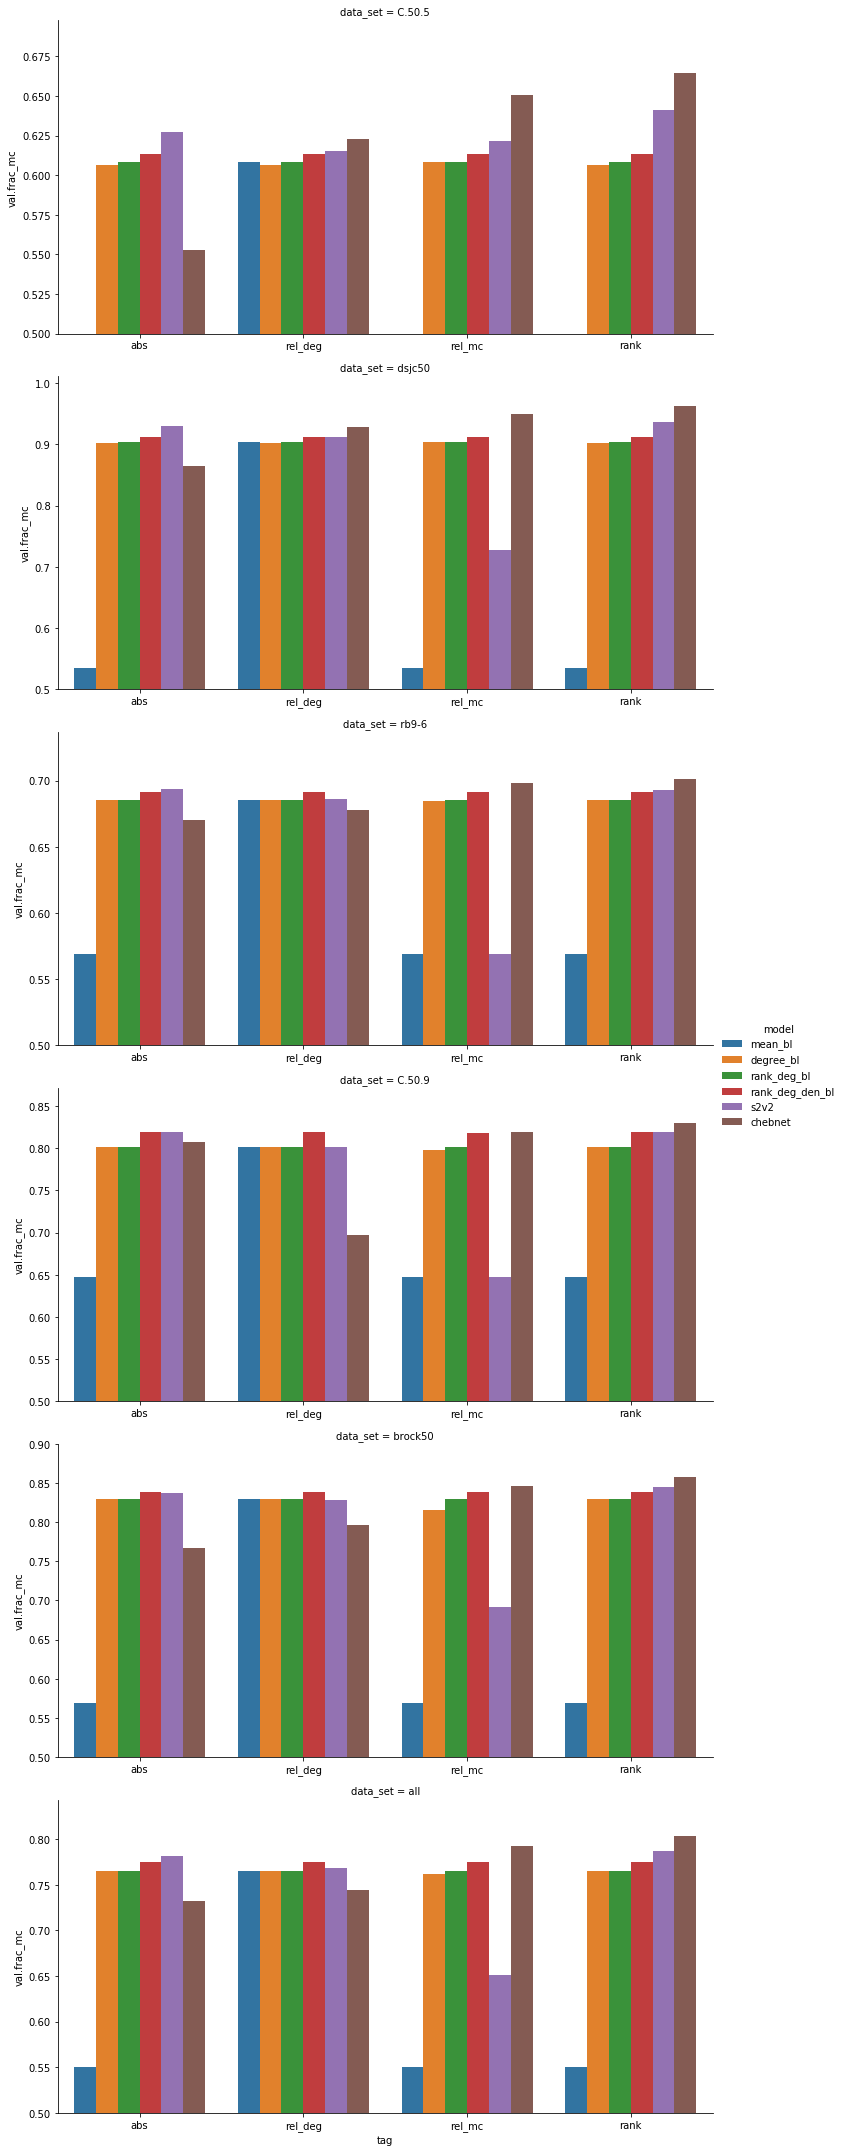

In [6]:
rank_model_order = ["mean_bl", "degree_bl", "rank_deg_bl", "rank_deg_den_bl", "s2v2", "chebnet"]
rank_tag_order = ["abs", "rel_deg", "rel_mc", "rank"]

grid = sns.catplot(data=results[(results.train == False)], 
            x="tag", y="val.frac_mc", row="data_set", hue="model",
            hue_order=rank_model_order, order=rank_tag_order, 
            kind="bar", sharey=False, sharex=False, aspect=2)
for i in range(6):
    grid.axes[i, 0].set_ylim(0.5)

### Generate table

In [7]:
col_order = [
    "mean_bl_subset+abs",
    "rank_deg_bl+abs",
    "rank_deg_den_bl+abs",
    
    "s2v2+abs",
    "chebnet+abs",
    
    "s2v2+rel_deg",
    "chebnet+rel_deg",
    
    "s2v2+rank",
    "chebnet+rank",
]
table = results[["model", "tag", "data_set", "val.frac_mc"]]
table["model_tag"] = table["model"] + "+" + table["tag"]
table = table.pivot("data_set", "model_tag", "val.frac_mc").round(3)[col_order]
table

/home/mario/Documents/matfyz/mcp-gnns/env/lib/python3.5/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


model_tag,mean_bl_subset+abs,rank_deg_bl+abs,rank_deg_den_bl+abs,s2v2+abs,chebnet+abs,s2v2+rel_deg,chebnet+rel_deg,s2v2+rank,chebnet+rank
data_set,,,,,,,,,
C.50.5,0.431,0.608,0.613,0.627,0.552,0.616,0.623,0.641,0.665
C.50.9,0.648,0.801,0.819,0.820,0.808,0.801,0.697,0.820,0.830
all,0.551,0.766,0.775,0.782,0.732,0.769,0.744,0.787,0.803
brock50,0.569,0.830,0.838,0.837,0.767,0.829,0.797,0.845,0.857
dsjc50,0.536,0.904,0.912,0.930,0.865,0.912,0.929,0.936,0.963
rb9-6,0.569,0.685,0.691,0.694,0.670,0.686,0.677,0.693,0.702


In [8]:
# with open("outputs/gen_size_fmc.tex", "w") as f:
#     f.write(table.to_latex())